# Example 4: Model Training
First we import the necessary modules

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pythermondt import S3Reader, DataContainer
from pythermondt import transforms as T
from pythermondt.dataset import ThermoDataset, random_split
from example_models.defect_classifier import UNetClassifier

First we define some general parameters for the model training

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set global random seed for reproducibility
torch.manual_seed(42)

# Model Hyperparameters
epochs = 50
batch_size = 32
learning_rate = 1e-4 # Standard learning rate for Adam optimizer

Using device: cuda


Now we can the define all the datasources used for training. Here you could specify multiple datasources (which are later combined using the dataset) if you need that. In this example we only use one datasource.

**Note:** For the S3Reader object we set the `download_files` flag to true. Therefore all the files are cached to a folder (.pythermondt_cache) in the current working directory. This makes training way faster, because the files are now only downloaded once and not every time the datasource is loaded. 

In [3]:
folder = "sanity_checked/noise_level0.025 confidence0.5"
base_path = "SAL-Dataset/" + folder
# Specify the datasource
no_defect = S3Reader(
    bucket="ffg-bp",
    prefix=base_path + "/no_defect",
    download_files=True,
    num_files=500
)

visible = S3Reader(
    bucket="ffg-bp",
    prefix=base_path + "/defect_visible",
    download_files=True,
    num_files = 500,
)

Now we can combine these datasources by creating a dataset.

In [4]:
# Create a Dataset
dataset = ThermoDataset(data_source=[no_defect, visible])

S3Reader:   0%|          | 0/500 [00:00<?, ?files/s]

S3Reader:   0%|          | 0/500 [00:00<?, ?files/s]

Next, we define the transformation pipelines that process the data before it’s fed into the model. For the training set, we apply data-augmentation techniques—such as flipping, rotating, or adding noise to simulate the camera’s NETD—while the test set uses a simpler, non-augmented pipeline. Consequently, we maintain two distinct pipelines: one for training and one for testing.

In [5]:
# Setup transform pipeline for training set
train_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(0),
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(64),
    T.RandomFlip(p_height=0.3, p_width=0.3), # Data Augmentation
    T.GaussianNoise(std=25e-3), # Data Augmentation
    T.MinMaxNormalize(),
])

val_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(0),
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(64),
    T.GaussianNoise(std=25e-3), # Data Augmentation
    T.MinMaxNormalize(),
])

Next we can split the dataset into a training and validation subset, using the random_split function provided with pyThermoNDT. This function takes the dataset and a list of proportions for each subset, along with the corresponding transformation pipelines. The `random_split` function ensures that the data is split randomly while applying the specified transformations to each subset.



In [6]:
# Split the dataset in train and test subsets
train_set, val_set = random_split(dataset, [0.8, 0.2], [train_pipeline, val_pipeline])

# Print the length of the subsets
print(f"Train set length: {len(train_set)}")
print(f"Test set length: {len(val_set)}")

Train set length: 800
Test set length: 200


Now in order to make the training faster, datasets can build an in-memory-cache of the data. This can be done by calling the `build_cache` method on the dataset. 

**How Transform Caching Works**

The caching system automatically splits your transform pipeline into two parts:
1. **Deterministic transforms** → Applied once and cached in memory
2. **Random transforms + everything after** → Applied at runtime during training

This avoids re-computing expensive deterministic operations while preserving randomness for data augmentation.

Here is an example of how this works in practice:

```python
train_pipeline = T.Compose([
    T.ApplyLUT(),                           # Deterministic ✓
    T.SubtractFrame(0),                     # Deterministic ✓  
    T.RemoveFlash(method='excitation_signal'), # Deterministic ✓
    T.NonUniformSampling(64),               # Deterministic ✓
    T.RandomFlip(p_height=0.3, p_width=0.3), # Random ❌ ← Split point
    T.GaussianNoise(std=25e-3),             # Random ❌
    T.MinMaxNormalize(),                    # Deterministic, but after random ❌
])
```

**After `build_cache()`:**
- **CACHED:** `ApplyLUT → SubtractFrame → RemoveFlash → NonUniformSampling`  
- **RUNTIME:** `RandomFlip → GaussianNoise → MinMaxNormalize`

**Key insight:** Everything after the first random transform runs at runtime, even if it's deterministic (like `MinMaxNormalize`). This ensures the transform order is preserved. So in order to get maximum performance, make sure to apply random transforms as late as possible in your pipeline.

**Performance Benefits**

- **3-5x faster data loading** during training
- Heavy preprocessing (LUT application, flash removal) computed only once
- Random augmentation still works correctly
- Data stored in fast memory instead of slow disk access

**Memory consideration:** If your machine doesn't have enough RAM to hold the entire dataset, comment out the `build_cache()` lines below. The dataset will load data from disk as needed during training.

In [7]:
# Build the cache for faster access
train_set.build_cache()
val_set.build_cache()

train_set.print_memory_usage()
val_set.print_memory_usage()

Building cache:   0%|          | 0/800 [00:00<?, ?files/s]

Building cache:   0%|          | 0/200 [00:00<?, ?files/s]

IndexedThermoDataset Overview:
------------------------------
Currently there are 800 items in the cache
Total memory usage of the cache: 4.23 GB


IndexedThermoDataset Overview:
------------------------------
Currently there are 200 items in the cache
Total memory usage of the cache: 1.06 GB




Before we can continue, we also need to write a custom collate function. All the readers and datasets always load data in form of Datacontainer objects. However, when training a model the input data needs to be in form of a tensor. Therefore the collate function extracts the data from all the Datacontainer objects in the current batch and stacks them along the batch dimension. It also makes sure that the shape of the data and the labels match the model input and output shape.

Putting all of this together, we can now create a Pytorch DataLoader for each of the subsets, which will be used to iterate over the data during training and validation. The DataLoader takes care of batching the data and shuffling it if necessary.

In [8]:
# Custom collate function to extract data and target from the DataContainers in the batch
def collate_fn(batch: list[DataContainer]) -> tuple[torch.Tensor, torch.Tensor]:
    # Extract data and target from the DataContainers
    tdata_list = []
    mask_list = []

    # Extract the data and label from the DataContainer
    for container in batch:
        # Extract datasets from the DataContainer
        tdata = container.get_dataset("/Data/Tdata")
        tdata = tdata.permute(2, 0, 1).float()  # Permute from (H, W, T) -> (T, H, W) and convert to float
        tdata_list.append(tdata)  # Append the tensor to the list
        mask_list.append(0 if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else 1)

    # Stack the tensors along the batch dimension
    data = torch.stack(tdata_list).to(device=device, dtype=torch.float32)
    label = torch.tensor(mask_list, device=device, dtype=torch.float32).unsqueeze(1)


    return data, label

# Create a DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Now lets verify that the loaders load the data with the correct dimensionality. The models expects the data in **B x T x H x W**:
* B ... Batch size
* H / W ... Height / Width
* T ... Time dimension

In [9]:
for data, label in train_loader:
    print("Data Shape: ", data.shape)
    print("Label Shape: ", label.shape)
    break

Data Shape:  torch.Size([32, 64, 100, 100])
Label Shape:  torch.Size([32, 1])


Now that we have defined all the transform pipelines, lets also verify that the input to the model is correct. Lets plot some images from the training set and test set to see if the transformations are applied correctly.

no-defect


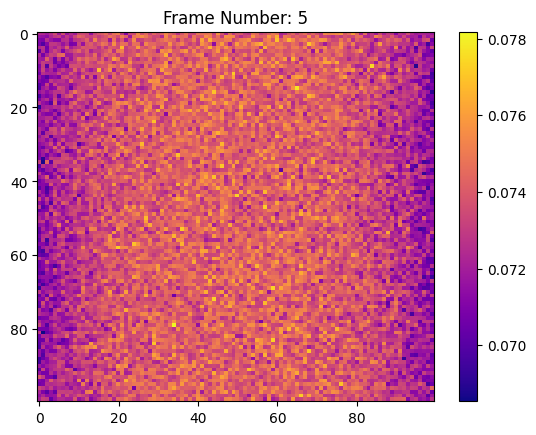

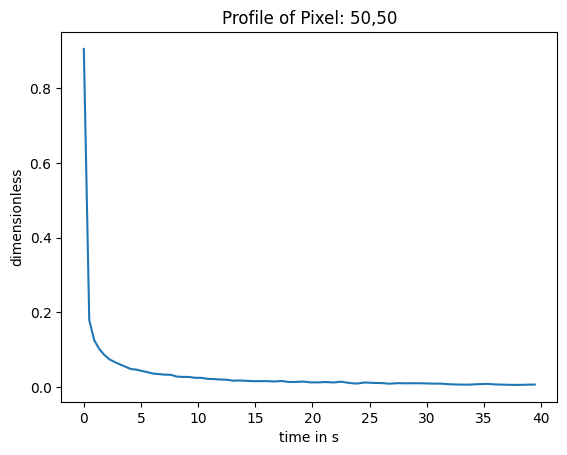

defect


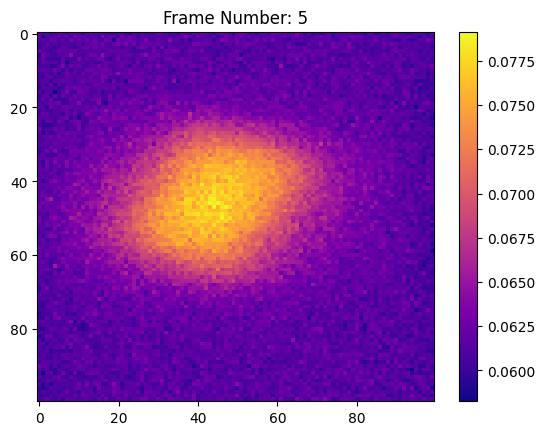

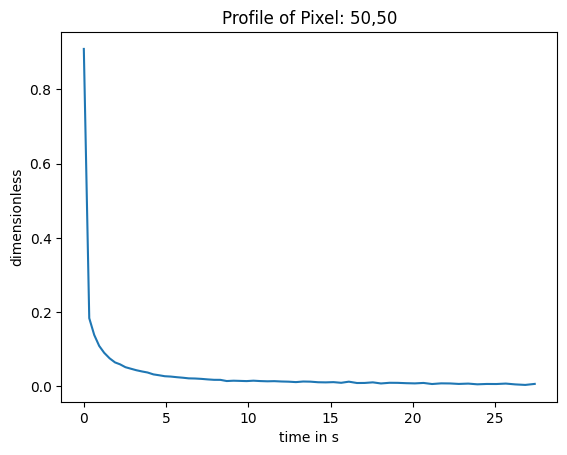

In [10]:
# Visualize the data input
# Visualize a no-defect sample
container = train_set[5]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

# Visualize a defect sample
container = train_set[2]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

Before the training can start, we also need to define the model, the loss function and the optimizer:

In [11]:
# Define the model and optimizer
model = UNetClassifier(time_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()

At this point, the training loop can be executed using the following code. This loop is straightforward and consists of only a few lines. For production use, consider adding features such as logging, early stopping, learning rate scheduling, etc.

In [12]:
from tqdm.auto import tqdm

# Initialize lists to store losses and metrics
train_losses = []
val_losses = []
val_accuracies = []

# Create a single progress bar that will be reused
pbar = tqdm(total=len(train_loader), desc="Training")

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    
    # Reset and update progress bar for training
    pbar.reset()
    pbar.set_description(f"Epoch {epoch+1}/{epochs} - Training")
    
    for batch_idx, (data, label) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, label)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item()

        # Update progress bar
        pbar.update(1)
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    # Average training loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss_summed = 0.0
    correct = 0
    total = 0
    
    # Reset and update progress bar for validation
    pbar.reset(total=len(val_loader))
    pbar.set_description(f"Epoch {epoch+1}/{epochs} - Validation")
    
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            # Forward pass
            output = model(data)

            # Compute the loss
            loss = loss_fn(output, label)
            val_loss_summed += loss.item()
            
            # Calculate accuracy
            predictions = (torch.sigmoid(output) > 0.5).float()
            total += label.size(0)
            correct += (predictions == label).sum().item()
            
            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    # Calculate metrics
    avg_val_loss = val_loss_summed / len(val_loader)
    val_accuracy = correct / total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Reset progress bar total back to training loader size for next epoch
    pbar.reset(total=len(train_loader))

# Close progress bar
pbar.close()

# Print final statistics
print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)

# Find the best epoch with highest validation accuracy
best_epoch = val_accuracies.index(max(val_accuracies))
print(f"Best Epoch: {best_epoch+1}/{epochs}")
print(f"Train Loss: {train_losses[best_epoch]:.4f}")
print(f"Val Loss: {val_losses[best_epoch]:.4f}")
print(f"Val Accuracy: {val_accuracies[best_epoch]:.4f}")
print("="*50)

Training:   0%|          | 0/25 [00:00<?, ?it/s]


TRAINING COMPLETE
Best Epoch: 39/50
Train Loss: 0.1606
Val Loss: 0.1347
Val Accuracy: 0.9750


After the training loop has finished, the results can be visualized. In this example the loss curves are plotted over the training epochs:

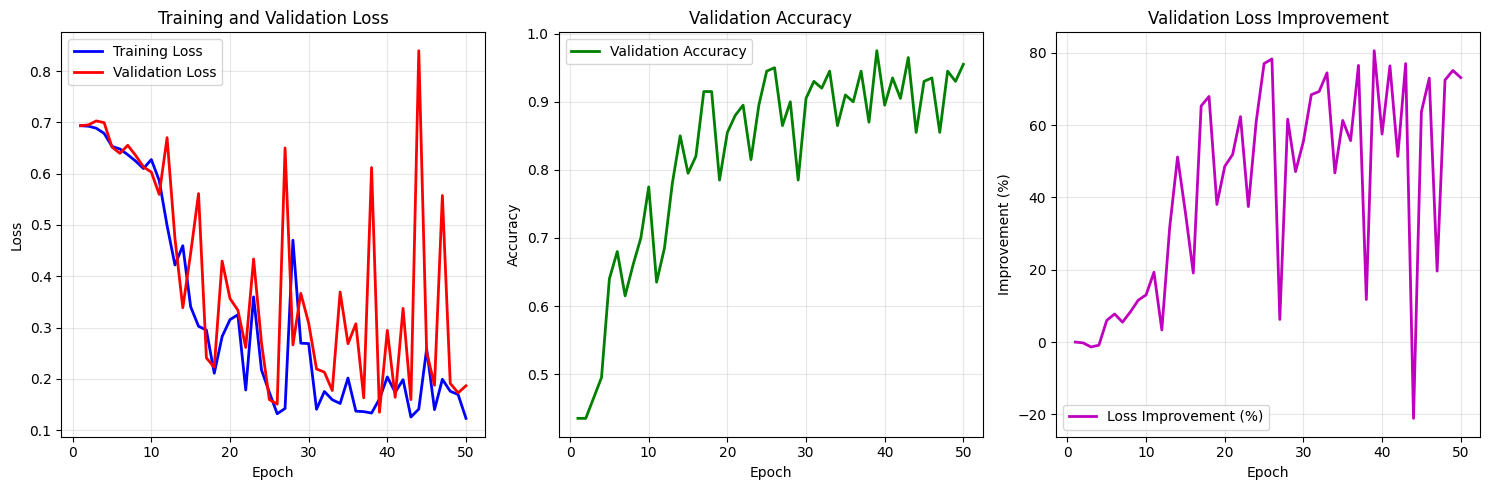

In [13]:
# Create loss curves
plt.figure(figsize=(15, 5))

# Plot 1: Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), val_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Loss Improvement
plt.subplot(1, 3, 3)
initial_val_loss = val_losses[0]
loss_improvement = [(initial_val_loss - loss) / initial_val_loss * 100 for loss in val_losses]
plt.plot(range(1, epochs + 1), loss_improvement, 'm-', label='Loss Improvement (%)', linewidth=2)
plt.title('Validation Loss Improvement')
plt.xlabel('Epoch')
plt.ylabel('Improvement (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Finally, the model`s weights are saved to a file. This file can later be used to load the model and make predictions on new data.

In [14]:
# Save the model
torch.save(model.state_dict(), "./example_models/defect_classifier.pth")